# Размещение баннеров

Представим, что международное круизное агентство Carnival Cruise Line решило себя разрекламировать с помощью баннеров и обратилось для этого к вам. Чтобы протестировать, велика ли от таких баннеров польза, их будет размещено всего 20 штук по всему миру. Вам надо выбрать 20 таких локаций для размещения, чтобы польза была большой и агентство продолжило с вами сотрудничать.

Агентство крупное, и у него есть несколько офисов по всему миру. Вблизи этих офисов оно и хочет разместить баннеры — легче договариваться и проверять результат. Также эти места должны быть популярны среди туристов.

In [29]:
import numpy as np
import pandas as pd
from sklearn.cluster import MeanShift
import seaborn as sns
from geopy.distance import geodesic

Для поиска оптимальных мест воспользуемся базой данных крупнейшей социальной сети, основанной на локациях — Foursquare.

Часть открытых данных есть, например, на сайте archive.org:

https://archive.org/details/201309_foursquare_dataset_umn

Скачайте любым удобным образом архив fsq.zip с этой страницы.

Нас будет интересовать файл checkins.dat.

Для удобной работы с этим документом преобразуем его к формату csv, удалив строки, не содержащие координат — они неинформативны для нас:

In [21]:
#Reading the data file
checkins = pd.read_csv('checkins.dat', sep='|', skipinitialspace=True, skiprows=[1], low_memory=False)
print(checkins.info())
checkins.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1021967 entries, 0 to 1021966
Data columns (total 6 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   id                1021967 non-null  object 
 1   user_id           1021966 non-null  float64
 2   venue_id          1021966 non-null  float64
 3   latitude          396634 non-null   float64
 4   longitude         396634 non-null   float64
 5   created_at        1021966 non-null  object 
dtypes: float64(4), object(2)
memory usage: 46.8+ MB
None


,id,user_id,venue_id,latitude,longitude,created_at
0,984301,2041916.0,5222.0,NaN,NaN,2012-04-21 17:39:01
1,984222,15824.0,5222.0,38.895112,-77.036366,2012-04-21 17:43:47
2,984315,1764391.0,5222.0,NaN,NaN,2012-04-21 17:37:18
3,984234,44652.0,5222.0,33.800745,-84.410520,2012-04-21 17:43:43
4,984249,2146840.0,5222.0,NaN,NaN,2012-04-21 17:42:58


In [22]:
#Stripping columns names (deleting whitespaces)
checkins.columns = checkins.columns.str.strip()

#Dropping rows with NaN values
checkins = checkins.dropna()
print('Shape without NaN: %s' % str(checkins.shape))
checkins.head()

Shape without NaN: (396634, 6)


,id,user_id,venue_id,latitude,longitude,created_at
1,984222,15824.0,5222.0,38.895112,-77.036366,2012-04-21 17:43:47
3,984234,44652.0,5222.0,33.800745,-84.410520,2012-04-21 17:43:43
7,984291,105054.0,5222.0,45.523452,-122.676207,2012-04-21 17:39:22
9,984318,2146539.0,5222.0,40.764462,-111.904565,2012-04-21 17:35:46
10,984232,93870.0,380645.0,33.448377,-112.074037,2012-04-21 17:38:18


Теперь необходимо кластеризовать данные координаты, чтобы выявить центры скоплений туристов. Поскольку баннеры имеют сравнительно небольшую площадь действия, нам нужен алгоритм, позволяющий ограничить размер кластера и не зависящий от количества кластеров.

Эта задача — хороший повод познакомиться с алгоритмом MeanShift. Его описание при желании можно посмотреть в sklearn user guide. Используйте MeanShift, указав bandwidth=0.1, что в переводе из градусов в метры колеблется примерно от 5 до 10 км в средних широтах.

Примечание: на 396634 строках кластеризация будет работать долго. Быть очень терпеливым не возбраняется — результат от этого только улучшится. Но для того, чтобы сдать задание, понадобится сабсет из первых 100 тысяч строк. Это компромисс между качеством и затраченным временем. Обучение алгоритма на всём датасете занимает около часа, а на 100 тыс. строк — примерно 2 минуты, однако этого достаточно для получения корректных результатов.

Некоторые из получившихся кластеров содержат слишком мало точек — такие кластеры не интересны рекламодателям. Поэтому надо определить, какие из кластеров содержат, скажем, больше 15 элементов. Центры этих кластеров и являются оптимальными для размещения.

Как мы помним, 20 баннеров надо разместить близ офисов компании. Найдем на Google Maps по запросу Carnival Cruise Line адреса всех офисов:

33.751277, -118.188740 (Los Angeles)

25.867736, -80.324116 (Miami)

51.503016, -0.075479 (London)

52.378894, 4.885084 (Amsterdam)

39.366487, 117.036146 (Beijing)

-33.868457, 151.205134 (Sydney)

Осталось определить 20 ближайших к ним центров кластеров. Т.е. посчитать дистанцию до ближайшего офиса для каждой точки и выбрать 20 с наименьшим значением.

In [23]:
checkins = checkins.head(10**5)

In [ ]:
meanshift = MeanShift(bandwidth=0.1, n_jobs=-1)
checkins["cluster"] = meanshift.fit_predict(checkins[["latitude", "longitude"]])

In [25]:
cluster_centers = pd.DataFrame(meanshift.cluster_centers_, columns=["latitude", "longitude"])
checkins['cluster_size'] = checkins.groupby('cluster')['cluster'].transform('count')

In [26]:
cluster_centers.shape

(3231, 2)

In [27]:
filtered_clusters = checkins[checkins['cluster_size'] > 15]
filtered_cluster_centers = cluster_centers.loc[filtered_clusters['cluster'].unique()]

In [28]:
filtered_cluster_centers.shape

(592, 2)

In [13]:
checkins

,id,user_id,venue_id,latitude,longitude,created_at,cluster,cluster_size
1,984222,15824.0,5222.0,38.895112,-77.036366,2012-04-21 17:43:47,5,2409
3,984234,44652.0,5222.0,33.800745,-84.410520,2012-04-21 17:43:43,7,1601
7,984291,105054.0,5222.0,45.523452,-122.676207,2012-04-21 17:39:22,30,594
9,984318,2146539.0,5222.0,40.764462,-111.904565,2012-04-21 17:35:46,65,186
10,984232,93870.0,380645.0,33.448377,-112.074037,2012-04-21 17:38:18,1,4692
...,...,...,...,...,...,...,...,...
233788,123888,1019078.0,1105563.0,33.575000,-117.725556,2011-12-11 05:38:19,50,355
233789,124366,771129.0,329847.0,37.629349,-122.400087,2011-12-11 04:55:34,4,3526
233793,125556,804990.0,254046.0,29.762884,-95.383061,2011-12-11 06:54:20,25,656
233797,127250,526214.0,34473.0,32.802955,-96.769923,2011-12-11 10:05:38,19,807


<Axes: xlabel='latitude', ylabel='longitude'>

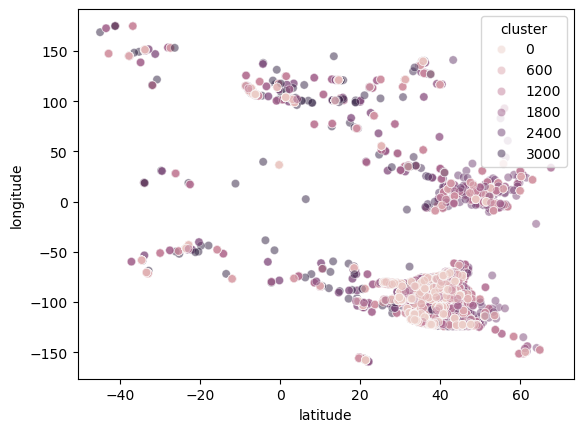

In [ ]:
sns.scatterplot(data=checkins, x="latitude", y="longitude", hue="cluster", alpha=0.5)

In [5]:
data = {
    "Latitude": [33.751277, 25.867736, 51.503016, 52.378894, 39.366487, -33.868457],
    "Longitude": [-118.188740, -80.324116, -0.075479, 4.885084, 117.036146, 151.205134],
    "City": ["Los Angeles", "Miami", "London", "Amsterdam", "Beijing", "Sydney"]
}

offices = pd.DataFrame(data)

In [ ]:
def distance(lat, lon, offices):
    distances = [geodesic((lat, lon), (row['Latitude'], row['Longitude'])).km for _, row in offices.iterrows()]
    return min(distances)

In [ ]:
filtered_cluster_centers['min_distance'] = filtered_cluster_centers.apply(
    lambda row: distance(row['latitude'], row['longitude'], offices), axis=1
)


filtered_cluster_centers.nsmallest(20, 'min_distance')

,latitude,longitude,min_distance
370,52.372964,4.892317,0.823444
420,-33.860630,151.204776,0.868755
419,25.845672,-80.318891,2.499839
58,51.502991,-0.125537,3.475846
51,33.809878,-118.148924,7.473233
29,25.785812,-80.217938,13.989509
167,25.705350,-80.283429,18.446966
87,33.888325,-118.048928,19.965422
92,26.010098,-80.199991,20.083482
42,33.872986,-118.362091,20.972689


Выберите из получившихся 20 центров тот, который наименее удален от ближайшего к нему офиса. Ответ в этом задании — широта и долгота этого центра, записанные через пробел.